In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import warnings
warnings.simplefilter("ignore")

In [39]:
df = pd.read_csv('dataset.csv', sep=";")
df.head()

,ID,booking,occupation_id_desc,had_a_flight_in_last_cruise,booked_country_aggregation,AGE,LOYALTY_TOTAL_SCORE,NUMBER_OF_CRUISES,rfm_segment,is_loyalty,...,flag_opt_cxl_last3y,flag_bkd_cxl_last_month,flag_opt_cxl_last_month,num_cruises_last3y,total_gross_cru_rev_eur_mean,total_gross_obr_rev_eur_mean,sent_last_month,open_last_month,click_last_month,source_desc
0,1,NaN,NaN,NaN,FRANCE,48,0,0,PROSPECT,False,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,RESERVATION SYSTEM
1,2,NaN,NaN,False,ARGENTINA,76,5842,7,0 HIGH,True,...,NaN,NaN,NaN,6.0,1197.578263,108.833333,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,ITALY,42,0,0,PROSPECT,True,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,WEB
3,4,NaN,NaN,False,GERMANY,33,0,1,LOST,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,ITALY,44,0,0,PROSPECT,True,...,1.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,WEB


In [40]:
df.isnull().sum()

ID                                   0
booking                          10000
occupation_id_desc               97272
had_a_flight_in_last_cruise      31934
booked_country_aggregation           0
AGE                                  0
LOYALTY_TOTAL_SCORE                  0
NUMBER_OF_CRUISES                    0
rfm_segment                          0
is_loyalty                           0
pcc_flag                             0
flag_app                           101
opener_segment                   63964
privacy_channel_email_date       46151
privacy_channel_phone_date       46311
privacy_channel_post_date        46840
privacy_send_material_date       35622
loyalty_subscribe_date           65402
days_after_cruise_end            40165
BKG_Channel                      33578
last_cruise_program_desc         32217
last_cruise_duration             32116
last_cruise_bkg_anticipation       100
last_paid_cabin_meta_cat_code    32233
last_nps_segment                 92871
last_pax_type            

In [41]:
df.drop(columns=[
                  "occupation_id_desc", "privacy_channel_email_date", "privacy_channel_phone_date", "privacy_channel_post_date",
                  "privacy_send_material_date", "loyalty_subscribe_date", "last_nps_segment", "flag_bkd_cxl_last3y",
                  "flag_bkd_cxl_last_month", "flag_opt_cxl_last3y", "flag_opt_cxl_last_month", "num_cruises_last3y",
                  "total_gross_cru_rev_eur_mean", "total_gross_obr_rev_eur_mean", "source_desc", "last_pax_type"], 
                   axis=1, inplace=True) 
                     # opener_segment, 

In [42]:
df_test = df[df["booking"].isnull()].reset_index(drop=True)
df_model = df[df["booking"].notnull()].reset_index(drop=True)

In [43]:
mode_pcc_flag = df_model["flag_app"].mode().values[0]
df_model["flag_app"].fillna(mode_pcc_flag, inplace=True)

mode_last_cruise_duration = df_model["last_cruise_duration"].mode().values[0]
df_model["last_cruise_duration"].fillna(mode_last_cruise_duration, inplace=True)

median_last_anticipation = df_model["last_cruise_bkg_anticipation"].median()
df_model["last_cruise_bkg_anticipation"].fillna(median_last_anticipation, inplace=True)

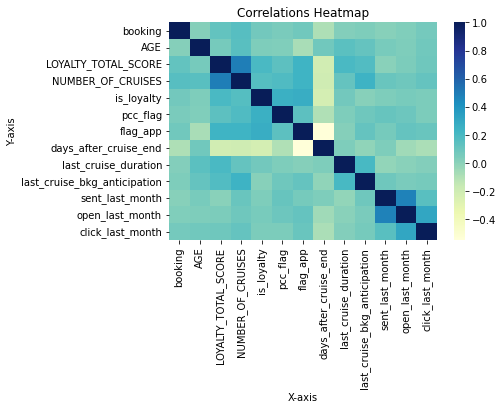

In [44]:
### the correlation between numerical features

df_corr = df_model.drop(columns=["ID"]).corr()  ## TODO: heatmap plotly

sns.heatmap(df_corr, cmap='YlGnBu')  # annot=True displays the data values on the heatmap
plt.title('Correlations Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [45]:
# BKG_Channel ==> already categorical
# last_cruise_program_desc ==> 35 categorie, we can make it 3categories or drop it 
# last_cruise_bkg_anticipation ==> fill 100 null with median : because of distribution
# last_paid_cabin_meta_cat_code ==> 6 categoryc
# last_pax_type ==> 165 category ==> droppiamo la colonna
# sent_last_month  ==> 0, 1-4, 4-
# open_last_month  ==> 0, 1-4, 4-
# click_last_month ==> 0, 1-4, 4-
# last_cruise_duration ==> per adesso fillna con la moda(7giorni)

## TODO: subplot the distribution with plotly
## TODO: logging instead of print

In [46]:
### segmenting the 'days_after_cruise_end' to a categorical column.

bins = [-np.inf, 90, 730, 1460, np.inf] ## based on their distribution
names = ['less_than_3month', 'between_3month_and_2year','between_2year_and_4year', 'more_than_4year']

df_model['period_after_cruise_end'] = pd.cut(df_model['days_after_cruise_end'], bins, labels=names)

df_model.drop(columns=["days_after_cruise_end"], axis=1, inplace=True)

In [47]:
### segmenting the 'click_last_month', 'open_last_month', 'sent_last_month' to categorical columns.

bins2 = [-np.inf, 0, 4, np.inf] ## based on their distribution
names2 = ['0', 'between_0_and_4','more_than_4']

df_model['category_click_last_month'] = pd.cut(df_model['click_last_month'], bins2, labels=names2)
df_model['category_open_last_month'] = pd.cut(df_model['open_last_month'], bins2, labels=names2)
df_model['category_sent_last_month'] = pd.cut(df_model['sent_last_month'], bins2, labels=names2)

df_model.drop(columns=["click_last_month", "open_last_month", "sent_last_month"], axis=1, inplace=True)

In [48]:
### encoding and scaling of categorical and numerical features

categorical_columns = ["had_a_flight_in_last_cruise", "BKG_Channel", "rfm_segment",  "period_after_cruise_end",
                        "last_paid_cabin_meta_cat_code", "category_open_last_month", 
                        "category_sent_last_month"
                        ] #,"last_cruise_program_desc", ,"category_click_last_month", "opener_segment"

numerical_columns = ["AGE", "LOYALTY_TOTAL_SCORE", "is_loyalty", "NUMBER_OF_CRUISES", "pcc_flag", "flag_app", 
                     "last_cruise_duration", "last_cruise_bkg_anticipation"
                      ] #

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_model[categorical_columns])
encoded_df = encoder.transform(df_model[categorical_columns]).toarray()
encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names(categorical_columns))



scaler = MinMaxScaler(feature_range=(0,1))

        # fit and transform the numerical columns of the dataframe
scaled_df = scaler.fit_transform(df_model[numerical_columns])

        # create a new dataframe with the scaled values
scaled_df = pd.DataFrame(scaled_df, columns=numerical_columns)

In [49]:
X = pd.concat([encoded_df, scaled_df], axis=1) ## merging the encoded categorical and numerical features

target_column = "booking"
y = df_model[target_column]

In [50]:
# split data into train and test sets
seed = 42
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [51]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=seed)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % len(y_res))

Resampled dataset shape 151244


In [52]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

# Assuming 'y' contains the class labels (0s and 1s) for the binary classification problem
class_weights = calculate_class_weights(y)
print("Class weights:", class_weights)

Class weights: {0.0: 0.5058851965104776, 1.0: 42.97946513849092}


In [53]:
clf = RandomForestClassifier(max_depth=3, random_state=seed, class_weight=class_weights) # ,  

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


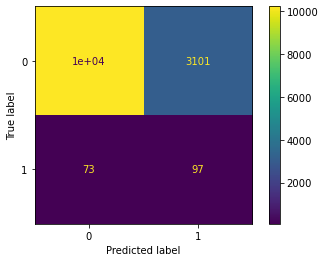

In [54]:
cm = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [121]:
print(recall_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

0.7648888888888888
0.9807925875175901
0.8555146454306939


In [ ]:
# filename = 'model_rfc.pkl'
# pickle.dump(clf, open(filename, 'wb'))

In [ ]:
### booking ==> imbalanced target column , i null saranno da prevedere
###*** occupation_id ==> 97k null (da togliere)
###* had_a_flight_in_last_cruise ==> 30k null che possiamo riempire con 0
### booked_country_aggregation ==> dopo la feature importance possiamo toglierla
### Age ==> 0 null e 18-123
### LOYALTY_TOTAL_SCORE ==> 0 null e bissogna fare scalling con 5 categorie
### number_of_cruise ==> 0 null
### rfm_segment ==> 0 null. one hot encoding to numerical
### is_loyalty ==> 0 null. TRUE e FALSE
### pcc_flag ==> 0 null. 0 e 1
### flag_app ==> 100 null. 0 e 1. fillna con 0 oppure dropna
###?? opener_segment ==> 64k null. bhoo per adesso?
###*** privacy_channel_email_date ==> 46k|
###*** privacy_channel_phone_date ==> 46k|
###*** privacy_channel_post_date  ==> 46k| colonne da togliere oppure creare quanti giorni da quella data è passato
###*** privacy_send_material_date ==> 35k| ma da capire che sono importanti o no.
###*** loyalty_subscribe_date ==> piu importante delle altre però 65k null.

###?? days_after_cruise_end ==> 40k null. da capire come gestirle??
###* BKG_Channel ==> 33k null. 6 distinct e mode frequency=42k
###* last_cruise_program_desc ==> 32k null. 35 categories e mode freq=40k
###* last_cruise_duration ==> 32k null. da 0 a 130gg. mode=7days e freq=44k
### last_cruise_bkg_anticipation ==> 100 null. da -11 a 1745. mode=0 e freq=33k
###* last_paid_cabin_meta_cat_code ==> 32k null. 6 category con quasi due mode: I e V
###*** last_nps_segment ==> 92k null. 3 category. probabimente da eliminare
###* last_pax_type    ==> 32k null.

###*** flag_bkd_cxl_last3y ==>     |75k null. mode=0, freq=16k
###*** flag_opt_cxl_last3y ==>     |75k null. mode=1, freq=13k
###*** flag_bkd_cxl_last_month ==> |75k null. there are 60 rows with 1 and 2. they are so meaningfull but we not enough data.
###*** flag_opt_cxl_last_month ==> |75k null. there are 700 rows not ZERO and NULL. they are so meaningfull but we not enough data.
###                                | eliminiamo le colonne ********

###*** num_cruises_last3y ==> 87k null. da eliminare 
###*** total_gross_cru_rev_eur_mean ==> 87k null. da eliminare 
###*** total_gross_obr_rev_eur_mean ==> 87k null. da eliminare 

### sent_last_month ==> | 70k null. 
### open_last_month ==> | 70k null. 
### click_last_month==> | 70k null. 

###*** source_desc ==> 63k null

In [ ]:
# TODO: plottare le distribuzioni
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# features_to_plot_dist = [ "AGE", "LOYALTY_TOTAL_SCORE", "NUMBER_OF_CRUISES",
#                          "rfm_segment", "flag_app", "days_after_cruise_end", "flag_app", "sent_last_month", 
#                          "last_cruise_duration"]

# fig = make_subplots(rows=1, cols=1)

# fig.add_trace(
#     go.Histogram(x1=df_model["AGE"], xaxis=[0, 150],
#     row=1, col=1)
# )
# # layout = dict(xaxis=dict(range=[-3, 3]))

# # fig.add_trace(
# #     go.Histogram(x=df_model["LOYALTY_TOTAL_SCORE"], xaxis=dict(range=[0, 10000]),
# #     row=1, col=2)
# # )



# fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
# fig.show()